In [15]:
baselines = {"Task001_adhesion_clf": 0.983, "Task002_nodule_clf": 0.959, "Task003_kidney_clf": 0.842,
             "Task004_skin_case_selection_clf": 0.996, "Task005_recist_timeline_clf": 0.944,
             "Task006_pathology_tumor_origin_clf": 0.631, "Task007_nodule_diameter_presence_clf": 0.870,
             "Task008_pdac_size_presence_clf": 0.640, "Task009_pdac_diagnosis_clf": 0.767, "Task010_prostate_radiology_clf": 0.975,
             "Task011_prostate_pathology_clf": 0.861, "Task012_pathology_tissue_type_clf": 0.428, "Task013_pathology_tissue_origin_clf": 0.669, "Task014_textual_entailment_clf": 0.577, "Task015_colon_pathology_clf": 0.991, "Task016_recist_lesion_size_presence_clf": 0.903, "Task017_pdac_attributes_clf": 0.639, "Task018_osteoarthritis_clf": 0.686,
             "Task019_prostate_volume_reg": 0.981, "Task020_psa_reg": 0.974, "Task021_psad_reg": 0.955, "Task022_pdac_size_reg": 0.854, "Task023_nodule_diameter_reg": 0.818,
             "Task024_recist_lesion_size_reg": 0.783}

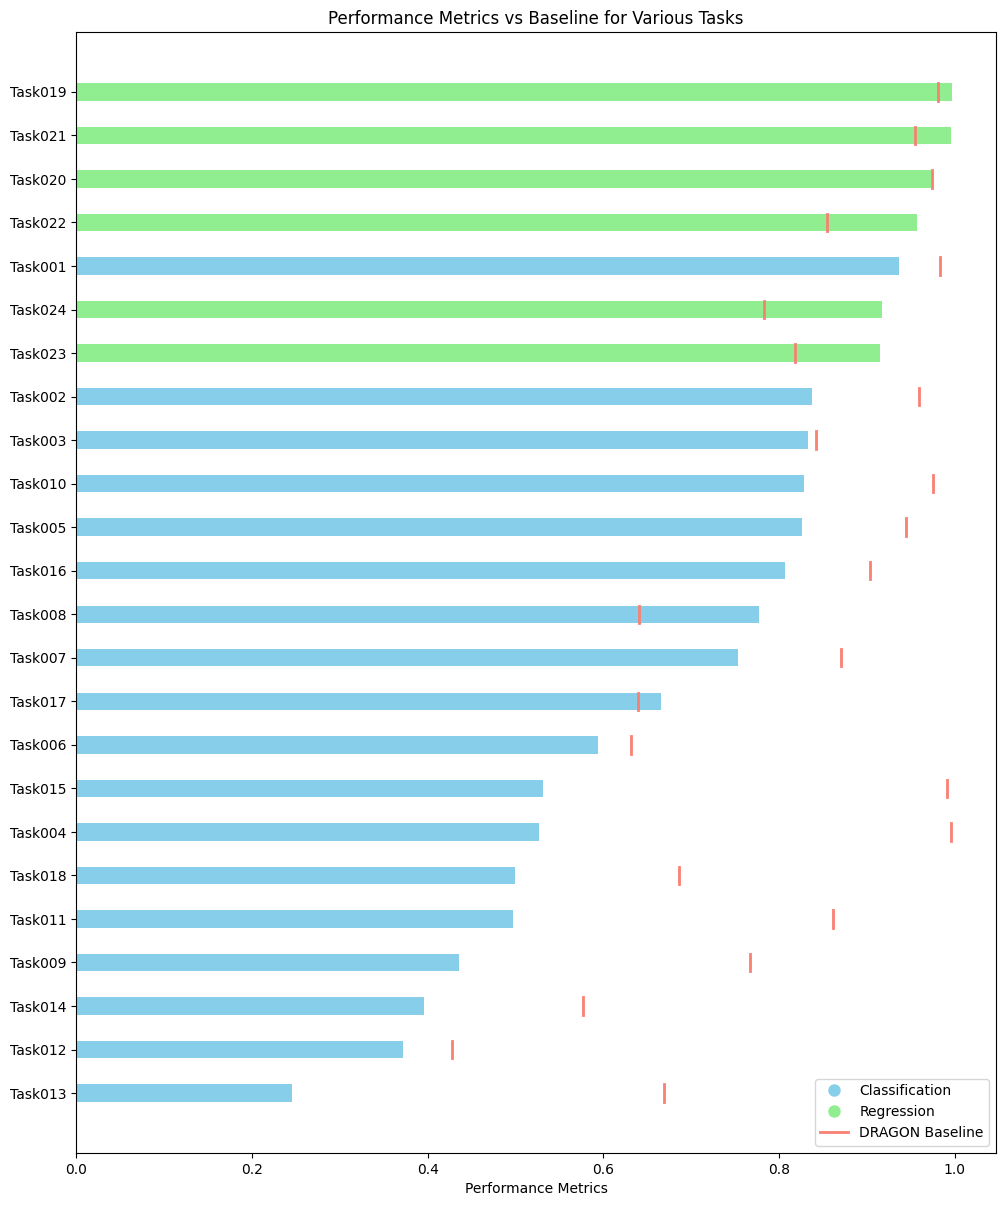

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Load metrics from JSON file
metricsfile = "/data/bodyct/experiments/luc_t10162/GitHub/LLM_data_extractor/output/mistral-nemo/0_examples/metrics.json"
with open(metricsfile, 'r') as file:
    metrics_data = json.load(file)

# Extract mean performance values from the metrics JSON
performance_data = {task: details['mean'] for task, details in metrics_data['aggregates'].items() if task != 'overall'}

# Create DataFrame from metrics and baselines
df_metrics = pd.DataFrame(list(performance_data.items()), columns=['Task', 'Performance'])
df_baselines = pd.DataFrame(list(baselines.items()), columns=['Task', 'Baseline'])
df = pd.merge(df_metrics, df_baselines, on='Task')

# Simplify task labels and categorize tasks
df['TaskID'] = df['Task'].apply(lambda x: x.split('_')[0])  # Extracts 'TaskXXX'
df['Category'] = df['Task'].apply(lambda x: 'clf' if 'clf' in x else 'reg')  # Categorize as 'clf' or 'reg'

# Sort tasks by performance in descending order
df = df.sort_values(by='Performance', ascending=False).reset_index(drop=True)

# Dynamically adjust figure height based on the number of tasks
task_count = len(df['Task'])
plt.figure(figsize=(10, 0.5 * task_count))  # Set height proportional to task count

y = range(task_count)

# Color coding for clf and reg tasks
colors = {'clf': 'skyblue', 'reg': 'lightgreen'}

# Horizontal bars for actual performance
for idx, row in df.iterrows():
    plt.barh(y=idx, width=row['Performance'], height=0.4, color=colors[row['Category']], label='_nolegend_')
    # Add a small line to indicate baseline performance
    plt.plot([row['Baseline'], row['Baseline']], [idx - 0.2, idx + 0.2], color='salmon', linewidth=2)

# Reverse the y-axis to show best performance at the top
plt.gca().invert_yaxis()

# Customize plot labels and legend
plt.yticks(ticks=y, labels=df['TaskID'])
plt.xlabel("Performance Metrics")
plt.title("Performance Metrics vs Baseline for Various Tasks")

# Custom legend for categories
clf_patch = plt.Line2D([0], [0], marker='o', color='w', label='Classification', markerfacecolor='skyblue', markersize=10)
reg_patch = plt.Line2D([0], [0], marker='o', color='w', label='Regression', markerfacecolor='lightgreen', markersize=10)
baseline_patch = plt.Line2D([0], [0], color='salmon', linewidth=2, label='DRAGON Baseline')
plt.legend(handles=[clf_patch, reg_patch, baseline_patch])

# Apply tight layout with minimal padding
plt.tight_layout(pad=0.5)
plt.show()
